In [6]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
from pprint import pprint
import sys

import ipywidgets as widgets
import matplotlib.pyplot as plt
from matplotlib import colors, gridspec
import numpy as np
from scipy.interpolate import interp1d
from scipy.signal import find_peaks, freqz

project_root = '..'
sys.path.append(project_root)

from sleeprnn.common import constants, pkeys, viz
from sleeprnn.common.optimal_thresholds import OPTIMAL_THR_FOR_CKPT_DICT
from sleeprnn.detection.feeder_dataset import FeederDataset
from sleeprnn.data import utils, stamp_correction
from sleeprnn.detection import metrics
from sleeprnn.helpers import reader, plotter, printer, misc, performer

RESULTS_PATH = os.path.join(project_root, 'results')

%matplotlib inline
viz.notebook_full_width()

In [2]:
dataset_name = constants.MASS_SS_NAME
fs = 200
dataset = reader.load_dataset(dataset_name, params={pkeys.FS: fs})

Train size: 11. Test size: 4
Train subjects: 
 [1, 3, 5, 7, 9, 10, 11, 14, 17, 18, 19]
Test subjects: 
 [2, 6, 12, 13]
Dataset mass_ss with 15 patients.
Loading from checkpoint... Loaded
Global STD: 16.482042


# RED performance (Validation, IoU >= 0.2)
Performance of RED-CWT model as a reference for exploratory analysis: We would like to find explanations to the errors, and to design new methods to deal with them and improve the model.

In [27]:
filter_dates = [20200724, None]
printer.print_available_ckpt(OPTIMAL_THR_FOR_CKPT_DICT, filter_dates)

Available ckpt:
    20200724_reproduce_red_n2_train_mass_ss/v19_rep2
    20200724_reproduce_red_n2_train_mass_ss/v19_rep4
    20200724_reproduce_red_n2_train_mass_ss/v19_rep1
    20200724_reproduce_red_n2_train_mass_ss/v19_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep2
    20200724_reproduce_red_n2_train_mass_ss/v11_rep3
    20200724_reproduce_red_n2_train_mass_ss/v11_rep4
    20200724_reproduce_red_n2_train_mass_ss/v11_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep3
    20200724_reproduce_red_n2_train_mass_kc/v19_rep2
    20200724_reproduce_red_n2_train_mass_kc/v19_rep1
    20200724_reproduce_red_n2_train_mass_kc/v19_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep3
    20200724_reproduce_red_n2_train_mass_kc/v11_rep2
    20200724_reproduce_red_n2_train_mass_kc/v11_rep4
    20200724_reproduce_red_n2_train_mass_kc/v11_rep1
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep2
    20200914_fft_based_norm_n2_train_mass_ss/v11_rep1
    20200914_fft_based_norm_

In [40]:
# Load predictions
which_expert = 1
task_mode = constants.N2_RECORD
seed_id_list = [0, 1, 2, 3]
set_list = [constants.VAL_SUBSET, constants.TRAIN_SUBSET]
iou_hist_bins = np.linspace(0, 1, 21)
iou_curve_axis = misc.custom_linspace(0.05, 0.95, 0.05)
ids_dict = {
    constants.ALL_TRAIN_SUBSET: dataset.train_ids,
    constants.TEST_SUBSET: dataset.test_ids}
ids_dict.update(misc.get_splits_dict(dataset, seed_id_list))

ref_ckpt_folder = '20200724_reproduce_red_n2_train_mass_ss/v19_rep1'
ref_predictions_dict = reader.read_prediction_with_seeds(
    ref_ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

# Compute performance by subject
iou_thr = 0.2

ref_precision_dict = {}
ref_recall_dict = {}
for seed_id in seed_id_list:
    # Prepare expert labels
    data_inference = FeederDataset(dataset, ids_dict[seed_id][constants.VAL_SUBSET], task_mode, which_expert)
    this_ids = data_inference.get_ids()
    this_events_list = data_inference.get_stamps()
    # Prepare model predictions
    prediction_obj = ref_predictions_dict[seed_id][constants.VAL_SUBSET]
    prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[ref_ckpt_folder][seed_id])
    this_detections_list = prediction_obj.get_stamps()
    for i, single_id in enumerate(this_ids):
        single_events = this_events_list[i]
        single_detections = this_detections_list[i]
        this_precision = metrics.metric_vs_iou(
            single_events, single_detections, [iou_thr], metric_name=constants.PRECISION)
        this_recall = metrics.metric_vs_iou(
            single_events, single_detections, [iou_thr], metric_name=constants.RECALL)
        ref_precision_dict[single_id] = this_precision[0]
        ref_recall_dict[single_id] = this_recall[0]
print("Done.")

Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200724_reproduce_red_n2_train_mass_ss/v19_rep1/seed3
Done.


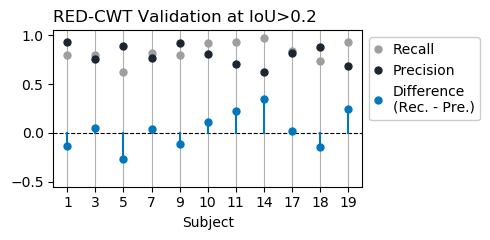

In [107]:
fig, ax = plt.subplots(1, 1, figsize=(5, 2.5), dpi=100)
color_recall = viz.GREY_COLORS[5]
color_precision = viz.PALETTE['dark']
color_difference = viz.PALETTE['blue']
markersize = 5

for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    ax.plot(
        i, ref_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, ref_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    difference = ref_recall_dict[single_id] - ref_precision_dict[single_id]
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.set_xlabel("Subject")
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("RED-CWT Validation at IoU>%1.1f" % iou_thr, loc="left")

plt.tight_layout()
plt.show()

# Change in performance after FFT-based normalization

In [58]:
# Load other predictions
new_ckpt_folder = '20200914_fft_based_norm_n2_train_mass_ss/v19_rep1'
new_predictions_dict = reader.read_prediction_with_seeds(
    new_ckpt_folder, dataset_name, task_mode, seed_id_list, set_list=set_list, parent_dataset=dataset)

# Compute performance by subject
iou_thr = 0.2

new_precision_dict = {}
new_recall_dict = {}
for seed_id in seed_id_list:
    # Prepare expert labels
    data_inference = FeederDataset(dataset, ids_dict[seed_id][constants.VAL_SUBSET], task_mode, which_expert)
    this_ids = data_inference.get_ids()
    this_events_list = data_inference.get_stamps()
    # Prepare model predictions
    prediction_obj = new_predictions_dict[seed_id][constants.VAL_SUBSET]
    prediction_obj.set_probability_threshold(OPTIMAL_THR_FOR_CKPT_DICT[new_ckpt_folder][seed_id])
    this_detections_list = prediction_obj.get_stamps()
    for i, single_id in enumerate(this_ids):
        single_events = this_events_list[i]
        single_detections = this_detections_list[i]
        this_precision = metrics.metric_vs_iou(
            single_events, single_detections, [iou_thr], metric_name=constants.PRECISION)
        this_recall = metrics.metric_vs_iou(
            single_events, single_detections, [iou_thr], metric_name=constants.RECALL)
        new_precision_dict[single_id] = this_precision[0]
        new_recall_dict[single_id] = this_recall[0]
print("Done.")

Loading predictions
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed0
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed1
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed2
Loaded /home/ntapia/projects/repos/sleep-rnn/results/predictions_mass_ss/20200914_fft_based_norm_n2_train_mass_ss/v19_rep1/seed3
Done.


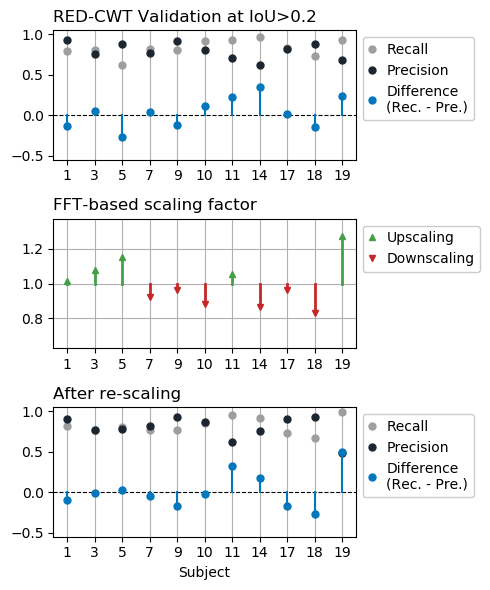

In [103]:
fig, axes = plt.subplots(3, 1, figsize=(5, 6), dpi=100)
color_recall = viz.GREY_COLORS[5]
color_precision = viz.PALETTE['dark']
color_difference = viz.PALETTE['blue']
markersize = 5

ax = axes[0]
for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    ax.plot(
        i, ref_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, ref_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    difference = ref_recall_dict[single_id] - ref_precision_dict[single_id]
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
# ax.set_xlabel("Subject")
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("RED-CWT Validation at IoU>%1.1f" % iou_thr, loc="left")

ax = axes[1]
subjects_scaling_dict = {}
mean_fft_scaling = 0
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    mean_fft_scaling += scaling_factor
    subjects_scaling_dict[subject_id] = scaling_factor
mean_fft_scaling /= len(dataset.train_ids)
factors_list = []
upscale_shown = False
downscale_shown = False
for i, single_id in enumerate(dataset.train_ids):
    factor = subjects_scaling_dict[single_id] / mean_fft_scaling
    factors_list.append(factor)
    color = viz.PALETTE['green'] if factor > 1 else viz.PALETTE['red']
    marker = "^" if factor > 1 else "v" 
    if factor > 1 and not upscale_shown:
        scale_label = "Upscaling"
        upscale_shown = True
    elif factor < 1 and not downscale_shown:
        scale_label = "Downscaling"
        downscale_shown = True
    else:
        scale_label = None
    ax.plot(
        i, factor, markersize=markersize, marker=marker, 
        color=color, linestyle="none", label=scale_label)
    ax.plot([i, i], [1, factor], color=color, linewidth=2)
max_delta = np.max(np.abs(factors_list) - 1) + 0.1
ax.set_ylim([1 - max_delta, 1 + max_delta])
ax.set_yticks([0.8, 1.0, 1.2])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
# ax.set_xlabel("Subject")
ax.grid()
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.set_title("FFT-based scaling factor", loc="left")

ax = axes[2]
for i, single_id in enumerate(dataset.train_ids):
    rec_label = "Recall" if i==0 else None
    pre_label = "Precision" if i==0 else None
    diff_label = "Difference\n(Rec. - Pre.)" if i==0 else None
    ax.plot(
        i, new_recall_dict[single_id], markersize=markersize, marker='o', 
        color=color_recall, label=rec_label, linestyle="none")
    ax.plot(
        i, new_precision_dict[single_id], markersize=markersize, marker='o', 
        color=color_precision, label=pre_label, linestyle="none")
    difference = new_recall_dict[single_id] - new_precision_dict[single_id]
    ax.plot(
        i, difference, markersize=markersize, marker='o', 
        color=color_difference, label=diff_label, linestyle="none")
    ax.plot([i, i], [0, difference], color=color_difference, linewidth=1.5)
ax.axhline(0, color="k", linewidth=0.8, linestyle="--", zorder=1)
ax.set_ylim([-0.55, 1.05])
ax.set_xticks(range(len(dataset.train_ids)))
ax.set_xticklabels(dataset.train_ids)
ax.set_xlabel("Subject")
ax.legend(loc="upper left", ncol=1, handlelength=0.5, framealpha=1, bbox_to_anchor=(1, 1))
ax.grid(axis="x")
ax.set_title("After re-scaling", loc="left")

plt.tight_layout()
plt.show()

# General Exploratory Analysis

# Spindle parameters

In [82]:
def analyze_spindle(spindle, fs):
    duration = spindle.size / fs
    pp_amplitude = spindle.max() - spindle.min()
    rms = np.sqrt(np.mean(spindle ** 2))
    central_freq_count = find_peaks(spindle)[0].size / duration
    # Compute peak frequency by fft
    w, h = freqz(spindle)
    resp_freq = w * fs / (2*np.pi)
    resp_amp = abs(h)
    max_loc = np.argmax(resp_amp)
    central_freq_fft = resp_freq[max_loc]
    results = {
        'duration': duration,
        'pp_amplitude': pp_amplitude,
        'rms': rms,
        'central_freq_count': central_freq_count,
        'central_freq_fft': central_freq_fft
    }
    return results


def listify_dictionaries(list_of_dicts):
    dict_of_lists = {}
    for key in list_of_dicts[0].keys():
        dict_of_lists[key] = []
        for single_dict in list_of_dicts:
            dict_of_lists[key].append(single_dict[key])
    return dict_of_lists

In [83]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    stamps = dataset.get_subject_stamps(subject_id, which_expert=1, pages_subset=constants.N2_RECORD)
    sigma_signal = utils.broad_filter(signal, fs, lowcut=9, highcut=17)
    spindles = [sigma_signal[s_start:s_end] for (s_start, s_end) in stamps]
    analysis = []
    for spindle in spindles:
        analysis_results = analyze_spindle(spindle, fs)
        analysis.append(analysis_results)
    analysis = listify_dictionaries(analysis)
    train_analysis.append(analysis)

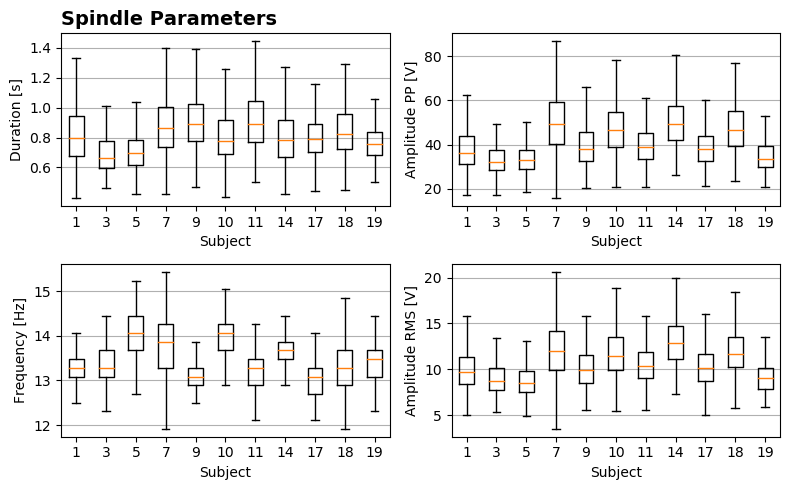

In [108]:
fig, axes = plt.subplots(2, 2, figsize=(8, 5), dpi=100)
showfliers = False

axes[0, 0].set_title("Spindle Parameters", fontweight='bold', loc="left", fontsize=14)

# Duration
ax = axes[0, 0]
ax.set_ylabel("Duration [s]")
ax.boxplot(
    [analysis['duration'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([0.6, 0.8, 1.0, 1.2, 1.4])

# Frequency
ax = axes[1, 0]
ax.set_ylabel("Frequency [Hz]")
ax.boxplot(
    [analysis['central_freq_fft'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([12, 13, 14, 15])
ax.set_xlabel("Subject")

# Amplitude PP
ax = axes[0, 1]
ax.set_ylabel("Amplitude PP [V]")
ax.boxplot(
    [analysis['pp_amplitude'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_yticks([20, 40, 60, 80])
ax.set_xlabel("Subject")

# Amplitude RMS
ax = axes[1, 1]
ax.set_ylabel("Amplitude RMS [V]")
ax.boxplot(
    [analysis['rms'] for analysis in train_analysis], 
    labels=dataset.train_ids, showfliers=showfliers,
    flierprops={'markersize': 2})
ax.grid(axis='y')
ax.set_xlabel("Subject")
ax.set_yticks([5, 10, 15, 20])

plt.tight_layout()
plt.show()

# Spectral parameters

In [109]:
def fft_based_scaling(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, _ = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    scaling_factor = 1 / np.mean(amp_all)
    return scaling_factor


def normalized_spectrum(signal, fs, pages, page_size):
    # Using FFT on whole page
    amp_all = []
    freq_all = []
    window_han = np.hanning(page_size)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        amp, freq = utils.power_spectrum(window_han * signal[start_page:end_page], fs)
        amp_all.append(amp)
        freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    # amp_all = amp_all / np.mean(amp_all)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_page = np.stack([freq_all, amp_all], axis=1)
    
    # Using FFT on 2-seconds segments
    amp_all = []
    freq_all = []
    window_size = 2 * fs
    window_han = np.hanning(window_size)
    n_windows = int(2 * (page_size / window_size) - 1)
    for page in pages:
        start_page = page * page_size
        end_page = start_page + page_size
        segment_signal = signal[start_page:end_page]
        for i in range(n_windows):
            start_window = int(i * window_size / 2)
            end_window = start_window + window_size
            window_signal = segment_signal[start_window:end_window] * window_han
            padding = np.zeros(1 * fs)
            window_signal_extended = np.concatenate([padding, window_signal, padding])
            amp, freq = utils.power_spectrum(window_signal_extended, fs)
            amp_all.append(amp)
            freq_all.append(freq)
    amp_all = np.stack(amp_all, axis=0).mean(axis=0)
    # amp_all = amp_all / np.mean(amp_all)
    freq_all = np.stack(freq_all, axis=0).mean(axis=0)
    spectrum_window = np.stack([freq_all, amp_all], axis=1)
    
    results = {
        'spectrum_page': spectrum_page,
        'spectrum_window': spectrum_window
    }
    return results

In [110]:
print("Correction factors if we want normalized FFT (integral equal to 1)")
mean_fft_scaling = 0
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    mean_fft_scaling += scaling_factor
    print("Subject %02d: %1.6f" % (subject_id, scaling_factor))
mean_fft_scaling /= len(dataset.train_ids)
print("Mean FFT Scaling: %1.6f" % mean_fft_scaling)

Correction factors if we want normalized FFT (integral equal to 1)
Subject 01: 10.916494
Subject 03: 11.553214
Subject 05: 12.373606
Subject 07: 9.929915
Subject 09: 10.336481
Subject 10: 9.480714
Subject 11: 11.303516
Subject 14: 9.269004
Subject 17: 10.320328
Subject 18: 8.929854
Subject 19: 13.672083
Mean FFT Scaling: 10.735019


In [117]:
train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    
    scaling_factor = 1.0
    # scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    
    analysis_results = normalized_spectrum(signal * scaling_factor, fs, n2_pages, dataset.page_size)    
    train_analysis.append(analysis_results)

spectrum_window


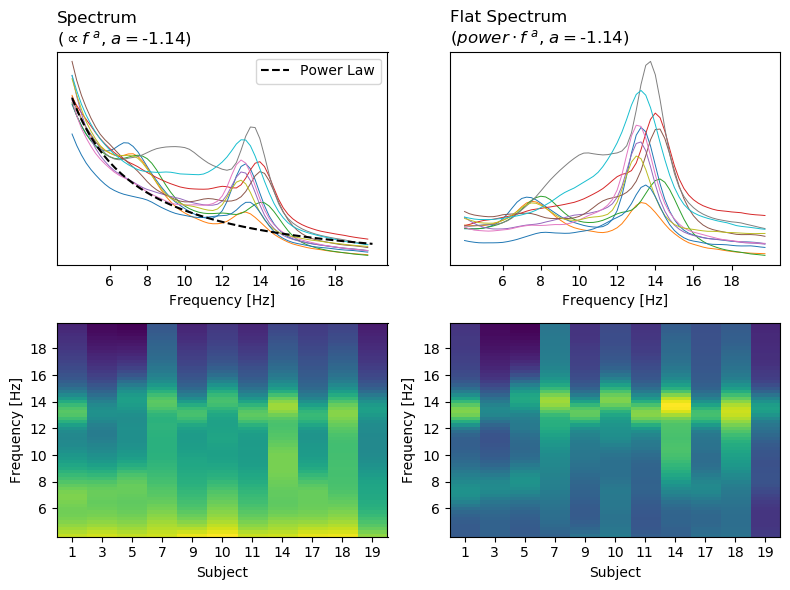

In [125]:
for chosen_key in ["spectrum_window"]:
    print(chosen_key)
    
    # Find tendency
    fit_lowcut = 1
    fit_highcut = 25
    coeffs = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - fit_lowcut) ** 2)
        last_freq_loc = np.argmin((freq_full - fit_highcut) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]        
        fit_x = np.log(freq)
        fit_y = np.log(power)
        coeff = np.polyfit(fit_x, fit_y, 1)
        coeffs.append(coeff)
    coeffs = np.stack(coeffs, axis=0).mean(axis=0)
    def tendency(frequencies):
        result = np.exp(coeffs[1]) * (frequencies ** coeffs[0])
        return result
    def flatten(frequencies, power):
        result = power / (frequencies ** coeffs[0])
        return result
    
    # Plots
    first_freq = 4#6
    last_freq = 20#18    
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)
    
    # Raw spectrum
    ax = axes[0, 0]
    subjects_spectrum_raw = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        ax.plot(freq, power, linewidth=0.7)
        spectrum_raw = np.stack([freq, power], axis=1)
        subjects_spectrum_raw.append(spectrum_raw)
    regr_freq = np.linspace(first_freq, last_freq)
    ax.plot(regr_freq, tendency(regr_freq), '--k', linewidth=1.5, label="Power Law")
    ax.legend(loc="upper right")
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Spectrum\n($\propto f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 0]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_raw], axis=0)
    freq_axis = subjects_spectrum_raw[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(np.log(spectrum_image.T), origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    # Flat spectrum
    ax = axes[0, 1]
    subjects_spectrum_flat = []
    for analysis in train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        power = flatten(freq, power)
        ax.plot(freq, power, linewidth=0.7)
        spectrum_flat = np.stack([freq, power], axis=1)
        subjects_spectrum_flat.append(spectrum_flat)
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Flat Spectrum \n($power\cdot f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 1]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_flat], axis=0)
    freq_axis = subjects_spectrum_flat[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(np.log(spectrum_image.T), origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    plt.tight_layout()
    plt.show()

In [123]:
scaled_train_analysis = []
for subject_id in dataset.train_ids:
    signal = dataset.get_subject_signal(subject_id, normalize_clip=False)
    hypno = dataset.get_subject_hypnogram(subject_id)
    n2_pages = np.where(hypno=="2")[0]
    
    # scaling_factor = 1.0
    scaling_factor = fft_based_scaling(signal, fs, n2_pages, dataset.page_size)
    
    analysis_results = normalized_spectrum(signal * scaling_factor, fs, n2_pages, dataset.page_size)    
    scaled_train_analysis.append(analysis_results)

spectrum_window


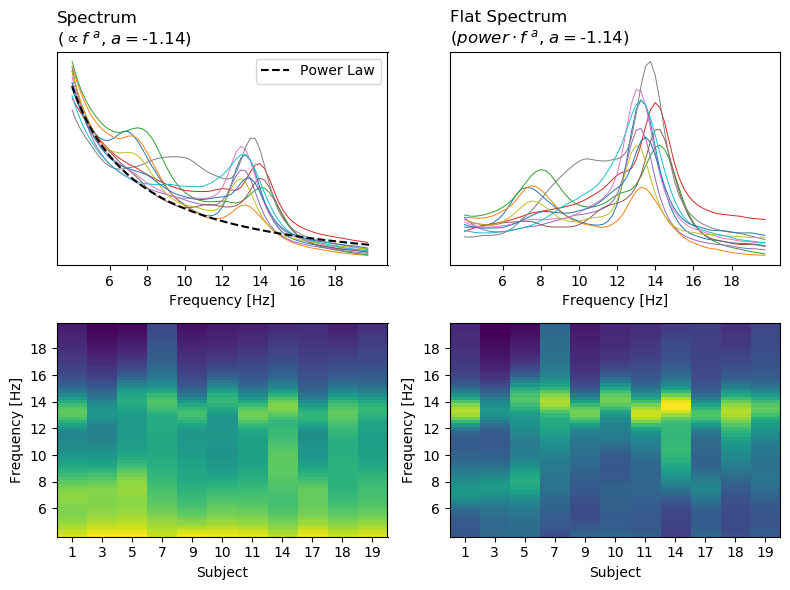

In [126]:
for chosen_key in ["spectrum_window"]:
    print(chosen_key)
    
    # Find tendency
    fit_lowcut = 1
    fit_highcut = 25
    coeffs = []
    for analysis in scaled_train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - fit_lowcut) ** 2)
        last_freq_loc = np.argmin((freq_full - fit_highcut) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]        
        fit_x = np.log(freq)
        fit_y = np.log(power)
        coeff = np.polyfit(fit_x, fit_y, 1)
        coeffs.append(coeff)
    coeffs = np.stack(coeffs, axis=0).mean(axis=0)
    def tendency(frequencies):
        result = np.exp(coeffs[1]) * (frequencies ** coeffs[0])
        return result
    def flatten(frequencies, power):
        result = power / (frequencies ** coeffs[0])
        return result
    
    # Plots
    first_freq = 4#6
    last_freq = 20#18    
    fig, axes = plt.subplots(2, 2, figsize=(8, 6), dpi=100)
    
    # Raw spectrum
    ax = axes[0, 0]
    subjects_spectrum_raw = []
    for analysis in scaled_train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        ax.plot(freq, power, linewidth=0.7)
        spectrum_raw = np.stack([freq, power], axis=1)
        subjects_spectrum_raw.append(spectrum_raw)
    regr_freq = np.linspace(first_freq, last_freq)
    ax.plot(regr_freq, tendency(regr_freq), '--k', linewidth=1.5, label="Power Law")
    ax.legend(loc="upper right")
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Spectrum\n($\propto f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 0]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_raw], axis=0)
    freq_axis = subjects_spectrum_raw[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(np.log(spectrum_image.T), origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    # Flat spectrum
    ax = axes[0, 1]
    subjects_spectrum_flat = []
    for analysis in scaled_train_analysis:
        freq_full = analysis[chosen_key][:, 0]
        first_freq_loc = np.argmin((freq_full - first_freq) ** 2)
        last_freq_loc = np.argmin((freq_full - last_freq) ** 2)
        freq = analysis[chosen_key][first_freq_loc:last_freq_loc, 0]
        power = analysis[chosen_key][first_freq_loc:last_freq_loc, 1]
        power = flatten(freq, power)
        ax.plot(freq, power, linewidth=0.7)
        spectrum_flat = np.stack([freq, power], axis=1)
        subjects_spectrum_flat.append(spectrum_flat)
    ax.set_yticks([])
    ax.set_xticks([6, 8, 10, 12, 14, 16, 18])
    ax.set_xlabel("Frequency [Hz]")
    ax.set_title("Flat Spectrum \n($power\cdot f^{\ a}$, $a=$%1.2f)" % coeffs[0], loc="left")
    
    ax = axes[1, 1]
    spectrum_image = np.stack([spectrum[:, 1] for spectrum in subjects_spectrum_flat], axis=0)
    freq_axis = subjects_spectrum_flat[0][:, 0]
    n_freqs = freq_axis.size
    show_freqs = np.array([6, 8, 10, 12, 14, 16, 18])
    show_ticks = (n_freqs - 1) * (show_freqs - freq_axis[0]) / (freq_axis[-1] - freq_axis[0])
    ax.imshow(np.log(spectrum_image.T), origin="lower", aspect="auto", interpolation="none")
    ax.set_xticks(np.arange(spectrum_image.shape[0]))
    ax.set_xticklabels(dataset.train_ids)
    ax.set_yticks(show_ticks)
    ax.set_yticklabels(show_freqs)
    ax.set_ylabel("Frequency [Hz]")
    ax.set_xlabel("Subject")
    
    plt.tight_layout()
    plt.show()

# Spindle spectral parameters
Like power ratios and spectrum of 2s centered on spindle